# Лабораторная работа №1



In [10]:
# Подключение библиотек
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

# Классификация Mnist

In [11]:
### Загрузка датасета
mnist = fetch_openml('mnist_784', version=1)

# Загрузка с масштабированием
x_data = mnist.data.values/255.0

# Метки в формате ohe
ohe = OneHotEncoder()
y_data = ohe.fit_transform(mnist.target.values.reshape(-1, 1)).toarray()

x_data.shape, y_data.shape

((70000, 784), (70000, 10))

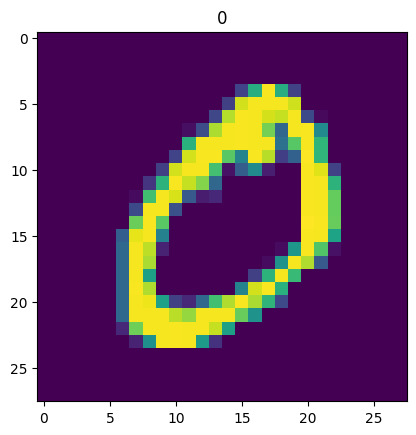

In [12]:
plt.imshow(x_data[1].reshape(28,28))
plt.title(np.argmax(y_data[1]))
pass

In [13]:
# 25% данных в тест, 75% в train:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=42, shuffle=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((52500, 784), (17500, 784), (52500, 10), (17500, 10))

In [14]:
# Для функции batches (пример):
def batches(x_data, y_data, batch_size):
    idxs = np.arange(len(x_data))
    np.random.shuffle(idxs)
    for start in range(0, len(x_data), batch_size):
        end = start + batch_size
        batch_idxs = idxs[start:end]
        yield x_data[batch_idxs], y_data[batch_idxs]

In [15]:
# Параметры
np.random.seed(42)

input_dim = 28 * 28
hidden_dim = 300
output_dim = 10
learning_rate = 0.1
batch_size = 32            
epochs = 20            

In [22]:
# Слои нейросети
W1 = np.random.randn(input_dim, hidden_dim) * 0.05
b1 = np.zeros((1, hidden_dim))
W2 = np.random.randn(hidden_dim, hidden_dim) * 0.05
b2 = np.zeros((1, hidden_dim))
W3 = np.random.randn(hidden_dim, output_dim) * 0.05
b3 = np.zeros((1, output_dim))

In [23]:
# Активации ReLU
def relu(x):
    return np.maximum(0, x)
def relu_dx(x):
    return (x > 0).astype(float)

In [24]:
# Активации Softmax
def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / exps.sum(axis=1, keepdims=True)

In [25]:
# Cross_entropy
def cross_entropy(y_true, y_pred):
    """
    ℒ(θ) = -1/N ∑_{i=1}^{N} ∑_{k=1}^{K} y_{i,k} log(p_{i,k})
    y_true, y_pred: shape (N, K)
    """
    eps = 1e-8
    y_pred = np.clip(y_pred, eps, 1 - eps)
    N = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred)) / N

In [26]:
# Обучение
losses = []
for epoch in range(epochs):
    # Шаги по всем доступным batch'ам:
    for x_batch, y_batch in batches(x_train, y_train, batch_size):  # batches — функция генерации батчей
        # Forward
        z1 = np.dot(x_batch, W1) + b1
        z2 = np.dot(z1, W2) + b2
        a2 = relu(z2)
        z3 = np.dot(a2, W3) + b3
        out = softmax(z3)

        # Loss
        losses.append(cross_entropy(y_batch, out))
        # dℒ/dz softmax + cross-entropy
        dz3 = (out - y_batch) / len(x_batch)

        # Backward
        dW3 = np.dot(a2.T, dz3)
        db3 = np.sum(dz3, axis=0, keepdims=True)
        da2 = np.dot(dz3, W3.T)
        dz2 = da2 * relu_dx(z2)

        dW2 = np.dot(z1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)
        dz1 = np.dot(dz2, W2.T) 

        dW1 = np.dot(x_batch.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # Обновление весов
        W3 -= learning_rate * dW3
        b3 -= learning_rate * db3
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1

    print(f'Epoch {epoch+1}/{epochs}, loss={losses[-1]:.8f}')

Epoch 1/20, loss=0.18678315
Epoch 2/20, loss=0.03165799
Epoch 3/20, loss=0.01360239
Epoch 4/20, loss=0.04480889
Epoch 5/20, loss=0.23132427
Epoch 6/20, loss=0.07101965
Epoch 7/20, loss=0.01320096
Epoch 8/20, loss=0.02413907
Epoch 9/20, loss=0.01547791
Epoch 10/20, loss=0.00143520
Epoch 11/20, loss=0.00208601
Epoch 12/20, loss=0.00213299
Epoch 13/20, loss=0.02515477
Epoch 14/20, loss=0.00144522
Epoch 15/20, loss=0.00119926
Epoch 16/20, loss=0.00054817
Epoch 17/20, loss=0.00441364
Epoch 18/20, loss=0.00382789
Epoch 19/20, loss=0.00106482
Epoch 20/20, loss=0.00055054


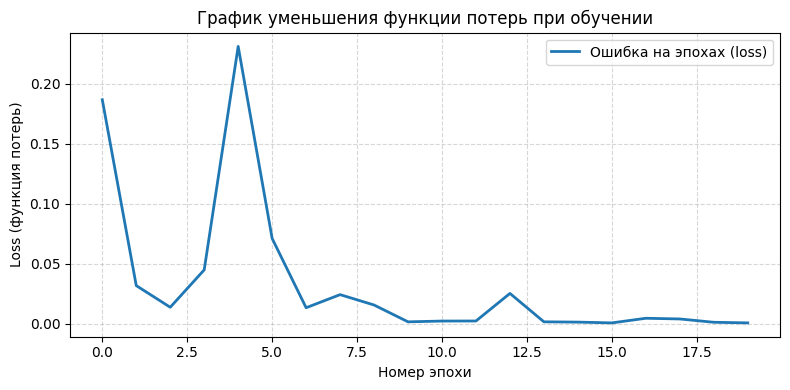

In [38]:
# График ошибки
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Ошибка на эпохах (loss)', linewidth=2)

plt.title('График уменьшения функции потерь при обучении')
plt.xlabel('Номер эпохи')
plt.ylabel('Loss (функция потерь)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

pass

In [39]:
# Функция вычиления меток
def predict(x_test):
    z1 = np.dot(x_test, W1) + b1
    z2 = np.dot(z1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    out = softmax(z3)
    return np.argmax(out, axis=1) 

In [40]:
# Расчет меток на тесте
y_pred = predict(x_test)

In [41]:
# Вчисление точности
print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1714
           1       0.99      0.99      0.99      1977
           2       0.97      0.98      0.98      1761
           3       0.97      0.98      0.97      1806
           4       0.98      0.98      0.98      1587
           5       0.98      0.97      0.98      1607
           6       0.99      0.99      0.99      1761
           7       0.98      0.98      0.98      1878
           8       0.98      0.96      0.97      1657
           9       0.97      0.97      0.97      1752

    accuracy                           0.98     17500
   macro avg       0.98      0.98      0.98     17500
weighted avg       0.98      0.98      0.98     17500

